# Interface offline to sea spray parametrizations
---------------------------------------------------

- SURFEX/coupling_sltn.F90 : sea salt aerosol parametrisation
- SURFEX/mode_ssgf.F90 : sea spray generation functions

original  : 30.10.2024 - J. Pianezze

## Import packages and modules
-----------------------------------------

In [1]:
import sys, os
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from   matplotlib.colors import BoundaryNorm
from   mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
sys.path.append(os.path.abspath(os.curdir)+'/../src_python/SURFEX/')
import mode_ssgf

## Choose the file containing the forcing fields
-----------------------------------------

In [2]:
cfg_file_WW3 = '/home/piaj/03_workdir/3M_study_IANOS/devel_SEASPRAY/ww3.202009.nc'
cfg_file_MNH = '/home/piaj/03_workdir/3M_study_IANOS/devel_SEASPRAY/concat_OAV16.1.TST00.OUT.nc'

## Initialisation
-----------------------------------------

In [3]:
mode_ssgf.modd_csts.xg           = 9.80665
mode_ssgf.modd_csts.xpi          = 2*np.arcsin(1.0)
mode_ssgf.modd_csts.xkarman      = 0.4
mode_ssgf.modd_ocean_csts.xrhosw = 1024.0

## Read NetCDF file and variables
-----------------------------------------

### WW3

In [4]:
file_WW3 = netCDF4.Dataset(cfg_file_WW3)
lon_WW3  = file_WW3.variables['longitude']
lat_WW3  = file_WW3.variables['latitude']
nlon_WW3 = np.size(file_WW3.dimensions['longitude'])
nlat_WW3 = np.size(file_WW3.dimensions['latitude'])

hs_WW3    = file_WW3.variables['hs'] [2,:,:].reshape(nlat_WW3*nlon_WW3)
phioc_WW3 = file_WW3.variables['foc'][2,:,:].reshape(nlat_WW3*nlon_WW3)
cp_WW3    = file_WW3.variables['tp'] [2,:,:].reshape(nlat_WW3*nlon_WW3)*(9.81/(2.0*np.pi))

mss_WW3   = np.sqrt(file_WW3.variables['mssu'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0+
                    file_WW3.variables['mssc'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0)
wind_WW3  = np.sqrt(file_WW3.variables['uwnd'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0+
                    file_WW3.variables['vwnd'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0)
ustar_WW3 = np.sqrt(file_WW3.variables['uust'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0+
                    file_WW3.variables['vust'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0)

/tmp/ipykernel_27164/974529146.py:11: RuntimeWarning: invalid value encountered in sqrt
  mss_WW3   = np.sqrt(file_WW3.variables['mssu'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0+
/tmp/ipykernel_27164/974529146.py:13: RuntimeWarning: invalid value encountered in sqrt
  wind_WW3  = np.sqrt(file_WW3.variables['uwnd'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0+
/tmp/ipykernel_27164/974529146.py:15: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ustar_WW3 = np.sqrt(file_WW3.variables['uust'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0+
/tmp/ipykernel_27164/974529146.py:15: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  ustar_WW3 = np.sqrt(file_WW3.variables['uust'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0+
/tmp/ipykernel_27164/974529146.py:16: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  file_WW3.variables['vust'] [2,:,:].reshape(nlat_WW3*nlon_WW3)**2.0

### MNH

In [5]:
file_MNH  = netCDF4.Dataset(cfg_file_MNH)
lon_MNH   = file_MNH.variables['longitude'][1:-1,1:-1]
lat_MNH   = file_MNH.variables['latitude'][1:-1,1:-1]
nlon_MNH  = np.size(file_MNH.dimensions['ni'])-2
nlat_MNH  = np.size(file_MNH.dimensions['nj'])-2

rv_MNH    = file_MNH.variables['RVTLOW']  [2,1:-1,1:-1].reshape(nlat_MNH*nlon_MNH)
th_MNH    = file_MNH.variables['THTLOW']  [2,1:-1,1:-1].reshape(nlat_MNH*nlon_MNH)
pabs_MNH  = file_MNH.variables['PABSTLOW'][2,1:-1,1:-1].reshape(nlat_MNH*nlon_MNH)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
#      2.3. Compute rhoa and visa
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# rhoa = f(p,t,rv)
# visa = f(t)

# ini_cst.f90
avogadro  = 6.0221367E+23
boltz     = 1.380658E-23
md        = 28.9644E-3
mv        = 18.0153E-3
rd        = avogadro*boltz/md
rv        = avogadro*boltz/mv
p00       = 1.0E5
cpd       = 7.0*rd/2.0
tt        = 273.16

# normal_interpol.f90
# ZEXNT(:,:)= (PPABST(:,:,IKB)/XP00) ** (XRD/XCPD)
# au dessus de l'ocean : ZEXNA=ZEXNT
exna_MNH = (pabs_MNH/p00) ** (rd/cpd)

# ground_paramn.F90
# ZPA(:,:,:) = XP00 * ZEXNA(:,:,:) ** (XCPD/XRD)
# et donc ZPA=PPABST
p_MNH = pabs_MNH

# normal_interpol.f90
# ZTA(:,:,:) = ZTHA(:,:,:) * ZEXNA(:,:,:)
t_MNH = th_MNH * exna_MNH

# ground_paramn.F90
# ZRHOA(:,:,:) = ZPA(:,:,:)/(XRD * ZTA(:,:,:) * ((1. + (XRD/XRV)*ZRVA(:,:,:)) / (1. + ZRVA(:,:,:))))
rhoa_MNH = (p_MNH/(rd*t_MNH)) * ((1.0+(rd/rv)*rv_MNH) / (1.0+rv_MNH))

# coare30_flux.F90
# ZVISA(J) = 1.326E-5*(1.+6.542E-3*(ZTA(J)-XTT)+8.301E-6*(ZTA(J)-XTT)**2-4.84E-9*(ZTA(J)-XTT)**3)
visa_MNH = 1.326E-5*(1.+6.542E-3*(t_MNH-tt)+8.301E-6*(t_MNH-tt)**2-4.84E-9*(t_MNH-tt)**3)

## Compute sea spray aerosol fluxes
-----------------------------------------

In [6]:
sv_WW3,sa_WW3,vfm_WW3,fm_WW3 = mode_ssgf.mode_ssgf.b22a(ustar_WW3,wind_WW3,hs_WW3,cp_WW3,mss_WW3,phioc_WW3,rhoa_MNH,visa_MNH)

## Reshape variables from 1d to 2d
-----------------------------------------

In [7]:
wind_WW3  = wind_WW3.reshape (nlat_WW3,nlon_WW3)
hs_WW3    = hs_WW3.reshape   (nlat_WW3,nlon_WW3)
ustar_WW3 = ustar_WW3.reshape(nlat_WW3,nlon_WW3)
cp_WW3    = cp_WW3.reshape   (nlat_WW3,nlon_WW3)
mss_WW3   = mss_WW3.reshape  (nlat_WW3,nlon_WW3)
phioc_WW3 = phioc_WW3.reshape(nlat_WW3,nlon_WW3)
rhoa_MNH  = rhoa_MNH.reshape (nlat_MNH,nlon_MNH)
visa_MNH  = visa_MNH.reshape (nlat_MNH,nlon_MNH)

sv_WW3    = sv_WW3.reshape   (nlat_WW3,nlon_WW3)
sa_WW3    = sa_WW3.reshape   (nlat_WW3,nlon_WW3)
vfm_WW3   = vfm_WW3.reshape  (nlat_WW3,nlon_WW3)
fm_WW3    = fm_WW3.reshape   (nlat_WW3,nlon_WW3)

## Figure
-----------------------------------------

/tmp/ipykernel_27164/1033773836.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  bmap_pmsh = bmap.pcolormesh(lon_WW3[:,:],lat_WW3[:,:],hs_WW3[:,:],cmap=cmap_hs, norm=norm_hs)
/tmp/ipykernel_27164/1033773836.py:102: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  bmap_pmsh = bmap.pcolormesh(lon_WW3[:,:], lat_WW3[:,:], fm_WW3[:,:], cmap=cmap_flux, norm=norm_flux)


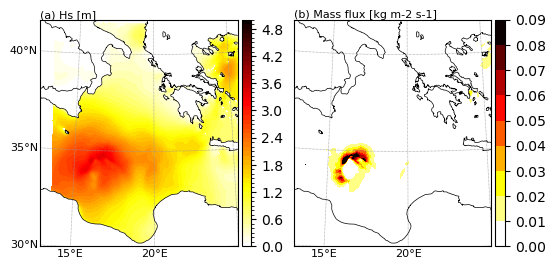

In [8]:
fig = plt.figure(figsize = (6,5))
gs  = gridspec.GridSpec(1,2)

# ---------------------------------------------------------
#    Add basemap
# ---------------------------------------------------------

bmap=Basemap(llcrnrlat=np.min(lat_WW3),llcrnrlon=np.min(lon_WW3),\
             urcrnrlat=np.max(lat_WW3),urcrnrlon=np.max(lon_WW3),\
             lat_1=np.min(lat_WW3),lat_2=np.max(lat_WW3),\
             lat_0=(np.min(lat_WW3)+np.max(lat_WW3))/2.0,\
             lon_0=(np.min(lon_WW3)+np.max(lon_WW3))/2.0,\
             projection='lcc',suppress_ticks=True, resolution = 'i')
    
mer=np.arange(-150, 200, 5.0)
par=np.arange(-120, 200, 5.0)
    
lon_WW3, lat_WW3 = bmap(lon_WW3, lat_WW3)

# ---------------------------------------------------------
#           ___________                  
#          |     |     |                  
#          |  X  |     |                  
#          |_____|_____|                  
#                                         
# ---------------------------------------------------------

ax00  = fig.add_subplot(gs[0,0])

# ---------------------------------------------------------
#    Add basemap info
# ---------------------------------------------------------

bmap.drawmeridians(mer, labels=[0, 0, 0, 1], fontsize=8, color='0.6', linewidth=0.5, ax=ax00)
bmap.drawparallels(par, labels=[1, 0, 0, 0], fontsize=8, color='0.6', linewidth=0.5, ax=ax00)
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='k',ax=ax00)

# ---------------------------------------------------------
#    Definition de la colormap
# ---------------------------------------------------------

cmap_hs=plt.get_cmap('hot_r')
    
# ---------------------------------------------------------
#    Definition des niveaux
# ---------------------------------------------------------

levels_hs = np.arange(0.0, 5.1, 0.1)
norm_hs   = BoundaryNorm(levels_hs, ncolors=cmap_hs.N, clip=True)
    
# ---------------------------------------------------------
#    Pcolormesh
# ---------------------------------------------------------

bmap_pmsh = bmap.pcolormesh(lon_WW3[:,:],lat_WW3[:,:],hs_WW3[:,:],cmap=cmap_hs, norm=norm_hs)
cbar      = bmap.colorbar(bmap_pmsh) 

# ---------------------------------------------------------
#    Add texts
# ---------------------------------------------------------

plt.text(0.0,1.0,r'(a) Hs [m]',\
         horizontalalignment='left',verticalalignment='bottom',\
         fontsize=8, transform = ax00.transAxes, color='k')

# ---------------------------------------------------------
#           ___________                  
#          |     |     |                  
#          |     |  X  |                  
#          |_____|_____|                  
#                                         
# ---------------------------------------------------------


ax01  = fig.add_subplot(gs[0,1])

# ---------------------------------------------------------
#    Add basemap info
# ---------------------------------------------------------

bmap.drawmeridians(mer, labels=[0, 0, 0, 1], fontsize=8, color='0.6', linewidth=0.5, ax=ax01)
bmap.drawparallels(par, labels=[0, 0, 0, 0], fontsize=8, color='0.6', linewidth=0.5, ax=ax01)
bmap.drawcoastlines(linewidth=0.5, linestyle='solid', color='k', ax=ax01)

# ---------------------------------------------------------
#    Definition de la colormap
# ---------------------------------------------------------

cmap_flux=plt.get_cmap('hot_r')
    
# ---------------------------------------------------------
#    Definition des niveaux
# ---------------------------------------------------------

levels_flux = np.arange(0.0, 0.1, 0.01)
norm_flux   = BoundaryNorm(levels_flux, ncolors=cmap_flux.N, clip=True)
    
# ---------------------------------------------------------
#    Pcolormesh
# ---------------------------------------------------------

bmap_pmsh = bmap.pcolormesh(lon_WW3[:,:], lat_WW3[:,:], fm_WW3[:,:], cmap=cmap_flux, norm=norm_flux)
cbar      = bmap.colorbar(bmap_pmsh) 

# ---------------------------------------------------------
#    Add texts
# ---------------------------------------------------------

plt.text(0.0,1.0,r'(b) Mass flux [kg m-2 s-1]',\
         horizontalalignment='left',verticalalignment='bottom',\
         fontsize=8, transform = ax01.transAxes, color='k')

# ---------------------------------------------------------
#    Save figure
# ---------------------------------------------------------
plt.savefig('hs_mass_flux_jupyter.png', bbox_inches='tight', dpi=400)